### Intro

You've probably seen the news talking about how a recession in the USA is coming. If you own some stock, maybe you could sell now and buy again when the recession is in full swing and make some money. This is crazy, everyone says don't do this. But here's a notebook where I put tried to calculate some leading indicators and see what they show. Please don't trade with this data it will ruin all my trades (haha, jk).

### Indicators

Here's the sources for the indicators:

- [Brookings - How Will We Know When a Recession is Coming](https://www.brookings.edu/blog/up-front/2019/06/06/how-will-we-know-when-a-recession-is-coming/). The Sahm indicator, it's a measure of unemployment change.
- [WSJ - Grading Bonds on Inverted Curve](https://www.wsj.com/articles/SB116821099838669658) plus [Vox - Yield Curve Explanation](https://www.youtube.com/watch?v=xiiHjrewXNI). The bond yield curve. By the way, it's already inverted in 2019...
- [Fed recession model](https://www.quandl.com/data/FRED/RECPROUSM156N-Smoothed-U-S-Recession-Probabilities). A complicated "dynamic-factor markov-switching model applied to four monthly coincident variables". Huh.

And here's some I looked at and didn't use:

- [FRED - GDPNow](https://www.frbatlanta.org/cqer/research/gdpnow). Realtime estimator of GDP growth. Not that leading?
- [Business Insider - 4500 truckers lost jobs in August 2019](https://www.businessinsider.com/trucking-bloodbath-4500-truck-drivers-lost-jobs-in-august-2019-9). Transportation volumes. The [Cass Freight Index](https://www.quandl.com/data/CASS/CFI-Cass-Freight-Index) and [TSI](https://www.transtats.bts.gov/OSEA/TSI/) are noisy, don't appear to lead that much?
- [Michigan Consumer Survey](https://www.quandl.com/data/UMICH/SOC1-University-of-Michigan-Consumer-Survey-Index-of-Consumer-Sentiment). Very noisy.
- [Phil. Econ. - The Single Greatest Predictor of Future Stock Market Returns](http://www.philosophicaleconomics.com/2013/12/the-single-greatest-predictor-of-future-stock-market-returns/). Allocation to equities metric with FRED data. Might be a great indicator, but it was annoying to calculate. Although [this guy](https://financial-charts.effingapp.com) made a nice plot of it.

### Discussion

There's a [hacker news thread](https://news.ycombinator.com/item?id=21364676) for this.

In [22]:
## Install these pre-requisites first.
# !pip install yfinance
# !pip install matplotlib
# !pip install quandl

In [2]:
# Get some stock data from yfinance.
import yfinance as yf  
yStartDate = '2008-01-01'
yEndDate = '2010-01-01'
spy = yf.download('SPY', yStartDate, yEndDate)
gld = yf.download('GLD', yStartDate, yEndDate)
sh = yf.download('SH', yStartDate, yEndDate)
sds = yf.download('SDS', yStartDate, yEndDate)
vbmfx = yf.download('VBMFX', yStartDate, yEndDate)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


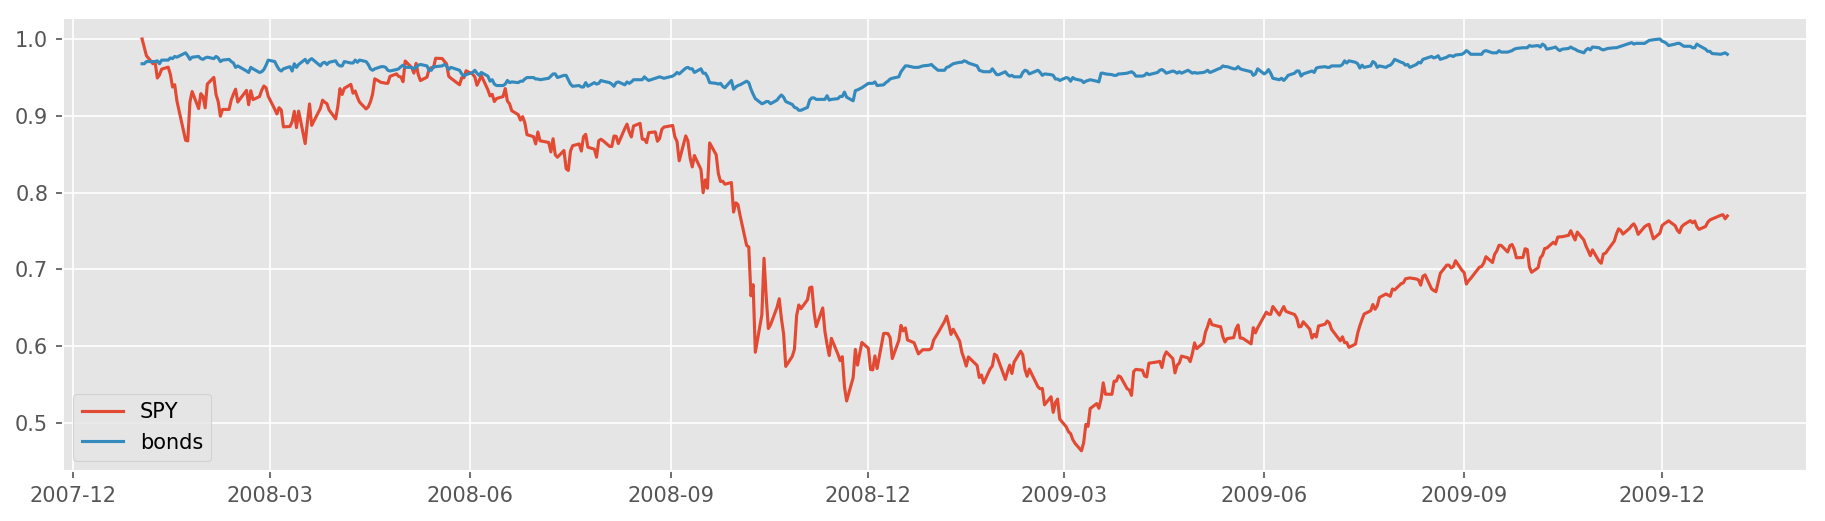

In [23]:
# Plot the yfinance data. It's the 2008 recession. Stocks were half price! :)
# If you're a madlad, uncomment that line that shows how short positions performed.
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(15,4), dpi=150)
plt.plot(spy.Open/max(spy.Open), label='SPY')
plt.plot(vbmfx.Open/max(vbmfx.Open), label='bonds')
# plt.plot(sds.Open/max(sds.Open), label='SDS') #ultra-short (4x) SP500 ETF
plt.legend();

In [26]:
# Now get some data from quandl for leading indicator calculation.
import quandl
# You'll probably need a new API key
quandl.ApiConfig.api_key = 'ZpK-75M-7KP4rzkhf5Cm'
# Get data
recInd = quandl.get('FRED/RECPROUSM156N') #recession predictor
isRec = quandl.get('FRED/JHDUSRGDPBR') #recession indicator (post-hoc)
unemp = quandl.get('FRED/UNRATE') #unemployment
sp500 = quandl.get('MULTPL/SP500_REAL_PRICE_MONTH')
curve = quandl.get('USTREASURY/YIELD')
gdpn = quandl.get('FRED/GDP')# 'FRED/GDPNOW')
# calculate derived values
curve['INV'] = curve['10 YR'] - curve['3 MO']
unemp['mean3'] = unemp['Value'].rolling(3).mean()
unemp['min12'] = unemp['Value'].rolling(12).min()
unemp['sahm'] = unemp['mean3'] - unemp['min12']

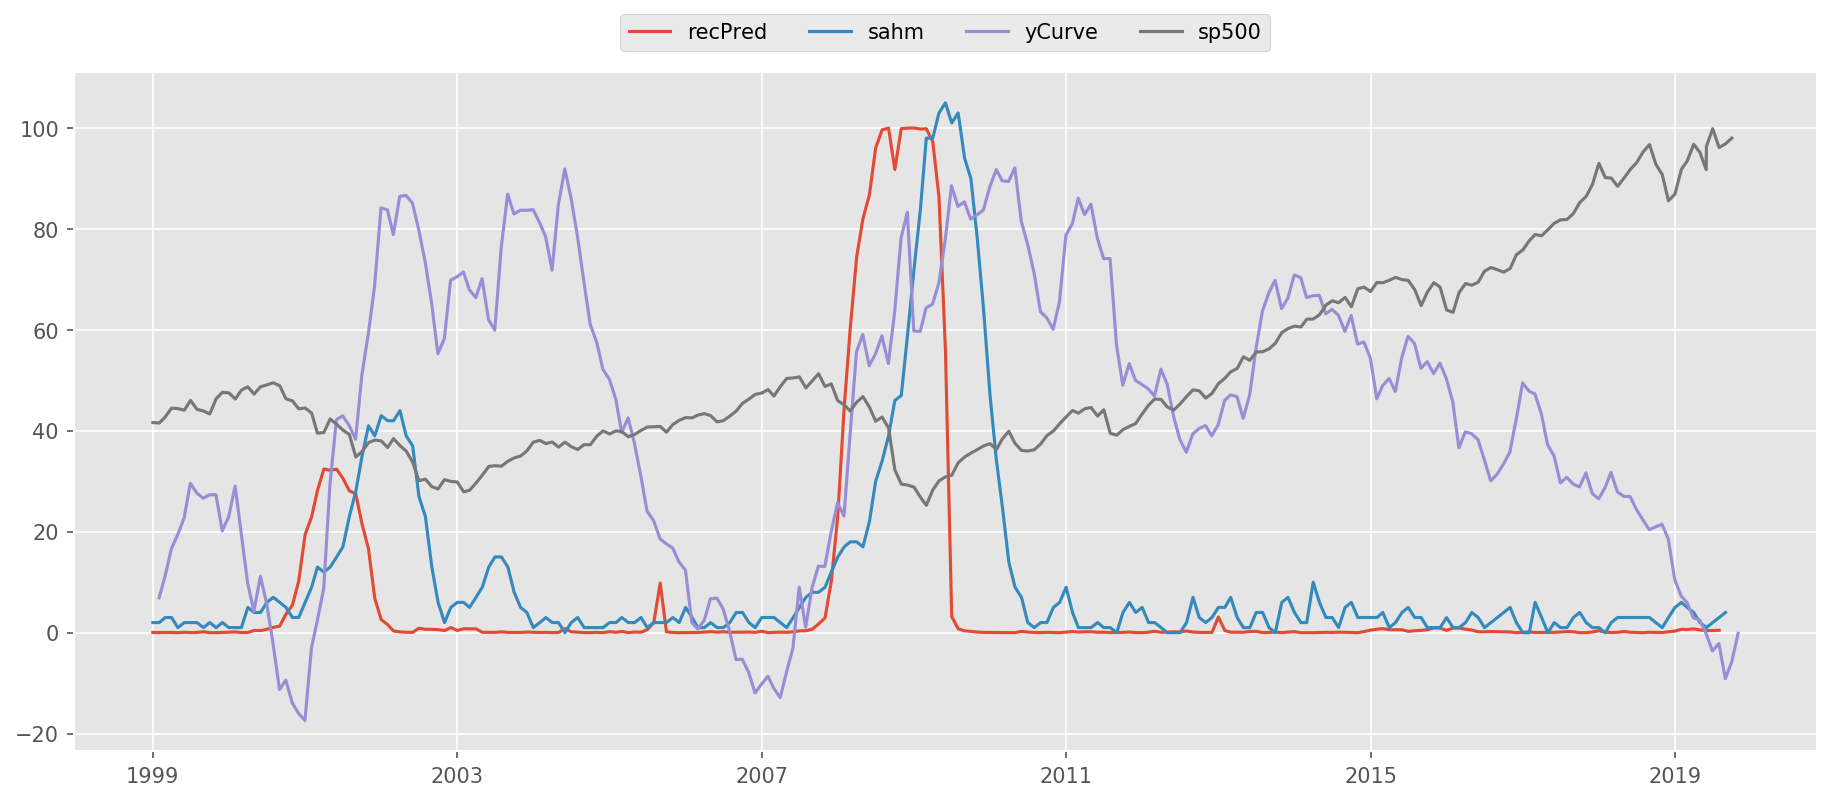

In [27]:
# Plot the recession indicators. Hey, these spike before(ish) the last two crashes.
startDate = '19990101'
plt.figure(figsize=(15,6), dpi=150)
plt.plot(recInd[startDate:], label='recPred')
# plt.plot(isRec[startDate:]*100.0, label='isRecess')
plt.plot(unemp['sahm'][startDate:]*30, label='sahm')
plt.plot(curve.resample('M').mean()['INV'][startDate:]*25, label='yCurve')
plt.plot(sp500[startDate:]/30, label='sp500')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, ncol=99);

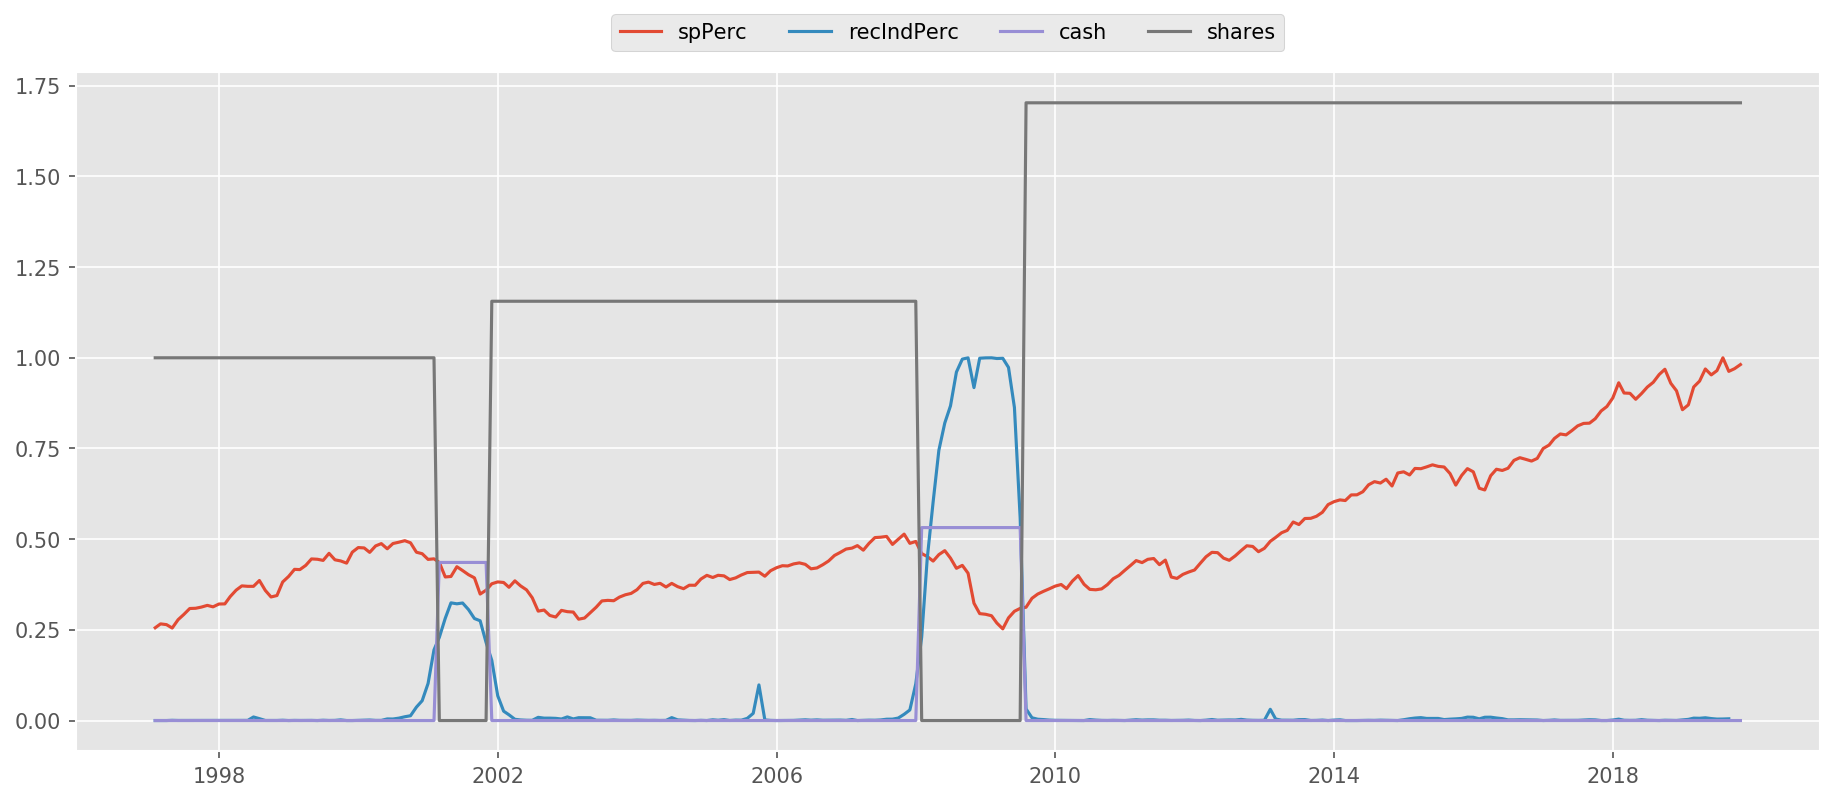

In [18]:
# Let's say you trade one of these, the FRED recession indicator. Do you make money? Sure, 1.75 your starting amount. Gulp.
trader = merged[['spPerc','recIndPerc']]['19970101':]
t2 = trader.resample('M').max()
t2.fillna(0.0)
t2.reset_index(inplace=True)
# Initial conditions, 1 share SP500 in 1999.
t2['cash'] = 0.0
t2['shares'] = 0.0
t2.at[0, 'shares'] = 1.0
TRIGGER = 0.2
# Look at the signals and calculate trades.
for i, row in t2.iterrows():
    if i == 0: continue
    t2.at[i, 'shares'] = t2.at[i-1, 'shares']
    t2.at[i, 'cash'] = t2.at[i-1, 'cash']
    if t2.at[i, 'recIndPerc'] >= TRIGGER and t2.at[i-1, 'recIndPerc'] <= TRIGGER:
        # Selling
        t2.at[i, 'cash'] = t2.at[i, 'spPerc'] * t2.at[i, 'shares']
        t2.at[i, 'shares'] = 0.0
    elif t2.at[i, 'recIndPerc'] <= TRIGGER and t2.at[i-1, 'recIndPerc'] >= TRIGGER:
        # Buying
        t2.at[i, 'shares'] = t2.at[i, 'cash'] / t2.at[i, 'spPerc']
        t2.at[i, 'cash'] = 0.0
# Charting
t2.set_index('Date', inplace=True)
plt.figure(figsize=(15,6), dpi=150)
plt.plot(t2)
plt.legend(t2.columns, loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, ncol=99);

In [19]:
# Mysterious auth hash 6c57b342c40418f384255e29bed8abaa4e158530bd0cbeedc7c273caebb5a3b333a5c2d5aef098e8f6a17f216120a4353b00a43213c9c90da7c113e930ce9b50